<!--NAVIGATION-->
# < [Autograd](2_Autograd.ipynb) | Regression | [Digit-Classification-MLP](4_MLP_Digit_Classification.ipynb)>

The main file is forked from dvgodoy/PyTorchStepByStep
## Deep Learning with PyTorch Step-by-Step: A Beginner's Guide
### Logistic Regression
<div dir="rtl">
در بخش رگرسیون شیوه‌ی استفاده از الگوریتم گرادیان کاهشی به صورتهای مختلف برای رگرسیون ملاحظه شد.
در این بخش به رگرسیون لاجیستیک خواهیم پرداخت.
</div>

اگر در گوکل کولب اجرا می‌کنید، دو دستور زیر را از حالت توضیح خارج کنید

In [332]:
# !git clone https://github.com/mamintoosi-cs/pytorch-workshop.git
# %cd pytorch-workshop


In [333]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
# This is needed to render the plots
from plots.utils import *
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

%matplotlib inline
sns.set()


In [334]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))


## Data Generation

### Synthetic Data Generation

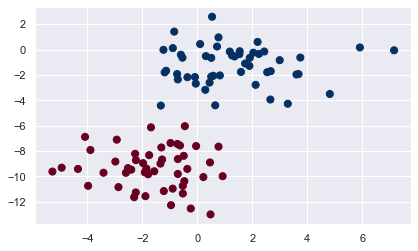

In [335]:
from sklearn.datasets import make_blobs
N = 100
X, y = make_blobs(N, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')


In [336]:
def normalize(X):

    # X --> Input.

    # m-> number of training examples
    # n-> number of features
    m, n = X.shape

    # Normalizing all the n features of X.
    for i in range(n):
        X = (X - X.mean(axis=0))/X.std(axis=0)

    return X


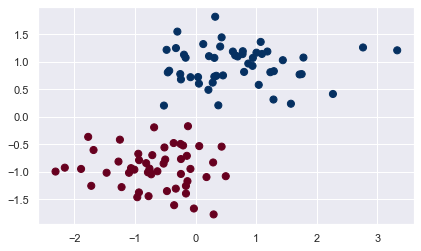

In [337]:
X = normalize(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')


In [338]:
# Add a column of 1s to X
ones = np.ones((N, 1))
print(X.shape, ones.shape)
x = np.concatenate([ones, X], axis=1)
print(x.shape)
print(x[:3])


(100, 2) (100, 1)
(100, 3)
[[ 1.          0.49867186 -1.07747003]
 [ 1.         -2.30915456 -0.99312925]
 [ 1.         -0.12466674 -0.16995376]]


### Train-Validation-Test Split

In [339]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [340]:
x_train.shape, y_train.shape


((80, 3), (80,))

According to Page 15 <a href="https://cs229.stanford.edu/main_notes.pdf"> Andrew Ng's Notes </a>:
$$
\Large
\begin{aligned}
 \epsilon_i &= y_i - \hat{y_i}\\
\end{aligned}
$$

According to Page 22 Andrew Ng's Notes:
$$
\large
\begin{aligned}
 \ell(\theta) &= \log L(\theta)\\
 &= \sum_{i=1}^n y_i \log\hat{y_i} + (1-y_i) \log(1-\hat{y_i})\\
\end{aligned}
$$

In [341]:
def loss_fn(y, y_hat):
    loss = np.mean(y*(np.log(y_hat)) + (1-y)*np.log(1-y_hat))
    return loss


In [342]:
# Initializes "w" randomly
np.random.seed(42)
w = np.random.randn(3, 1)
lr = 0.01
num_epochs = 100
Losses = np.empty(num_epochs)
for epoch in range(num_epochs):
    y_hat = sigmoid(x_train@w)
    error = y_train[:, np.newaxis] - y_hat
    loss = loss_fn(y_train, y_hat)
    Losses[epoch] = loss
    w_grad = (x_train * error).mean(axis=0)
    w_grad = np.reshape(w_grad, (3, 1))
    w = w + lr * w_grad

w


array([[0.38428266],
       [0.08295767],
       [0.93902231]])

In [343]:
y_hat_test = sigmoid(x_test@w)
print(y_test[:3], y_hat_test[:3].T)
y_pred = [int(x) for x in y_hat_test.round()]
accuracy = (y_pred == y_test).mean()
print(f"Accuracy {accuracy}")


[1 1 1] [[0.85760201 0.75257096 0.77861711]]
Accuracy 1.0


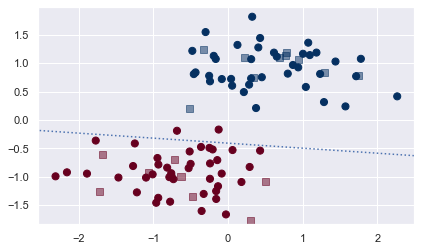

In [344]:
plt.scatter(x_train[:, 1], x_train[:, 2], c=y_train, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(x_test[:, 1], x_test[:, 2], c=y_pred,
            s=50, cmap='RdBu', alpha=0.5, marker='s')
plt.axis(lim)
# Generates evenly spaced x feature
x_range = np.linspace(-3, 3, 101)
# Computes yhat
yhat_range = -w[0]/w[2] - w[1]/w[2] * x_range
plt.plot(x_range, yhat_range, label='Decision Boundary', linestyle=':')

Now, with PyTorch

In [345]:
import torch
import torch.nn as nn

x_train, x_test, y_train, y_test = train_test_split(X, y[:,np.newaxis], test_size=0.2, random_state=42)
print(x_train.shape)

(80, 2)


In [346]:
# اگر از نوع دابل باشد خطا خواهیم گرفت
# x_train.dtype is float64
xTrain = torch.tensor(x_train, dtype=torch.float32)
yTrain = torch.tensor(y_train, dtype=torch.float32)
# بایاس رو به عهده خود مدل می‌گذاریم
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

learning_rate = 0.01
f = nn.BCELoss()  # binary cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 500
for epoch in range(num_epochs):
    y_hat = model(xTrain)
    loss = f(y_hat, yTrain)
    loss.backward()  # backward propagation: calculate gradients
    optimizer.step()  # update the weights
    optimizer.zero_grad()  # clear out the gradients from the last step loss.backward()

In [348]:
w = np.zeros(3)
w[0] = model[0].bias.detach().numpy()
w[1:] = model[0].weight.detach().numpy().squeeze()

In [349]:
xTest = torch.tensor(x_test, dtype=torch.float32)
yTest = torch.tensor(y_test, dtype=torch.float32)
with torch.no_grad():
    y_hat_test = model(xTest)
y_pred = y_hat_test.round().int()    
accuracy = (y_pred == yTest).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.949999988079071


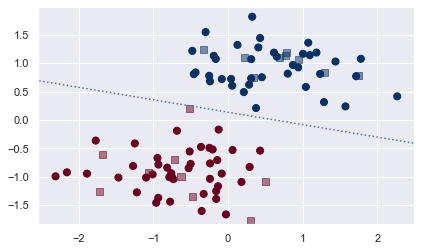

In [350]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred,
            s=50, cmap='RdBu', alpha=0.5, marker='s')
plt.axis(lim)

# Generates evenly spaced x feature
x_range = np.linspace(-3, 3, 101)
# Computes yhat
yhat_range = -w[0]/w[2] - w[1]/w[2] * x_range
plt.plot(x_range, yhat_range, label='Decision Boundary', linestyle=':')

<!--NAVIGATION-->
# < [Autograd](2_Autograd.ipynb) | Regression | [Digit-Classification-MLP](4_MLP_Digit_Classification.ipynb)>